In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as he
import numpy as np

In [2]:
df = pd.read_csv("log2.csv", header=0)
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [3]:
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

In [4]:
print(df.iloc[0])
df['Action'].value_counts()

Source Port             57222
Destination Port           53
NAT Source Port         54587
NAT Destination Port       53
Action                  allow
Bytes                     177
Bytes Sent                 94
Bytes Received             83
Packets                     2
Elapsed Time (sec)         30
pkts_sent                   1
pkts_received               1
Name: 0, dtype: object


Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

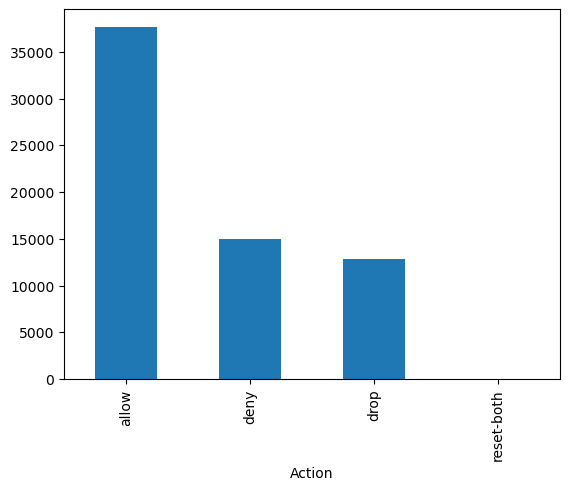

In [5]:
df['Action'].value_counts().plot(kind='bar')
plt.show()

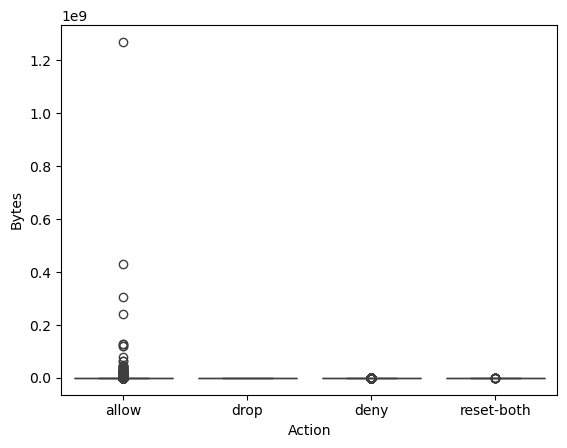

In [6]:
sns.boxplot(data=df, x='Action', y='Bytes')
plt.show()

In [7]:
df[['Bytes', 'Bytes Sent',       
    'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',       
    'pkts_received']] # Columns with numerical value

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,177,94,83,2,30,1,1
1,4768,1600,3168,19,17,10,9
2,238,118,120,2,1199,1,1
3,3327,1438,1889,15,17,8,7
4,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...
65527,314,192,122,6,15,4,2
65528,4680740,67312,4613428,4675,77,985,3690
65529,70,70,0,1,0,1,0
65530,70,70,0,1,0,1,0


<Axes: >

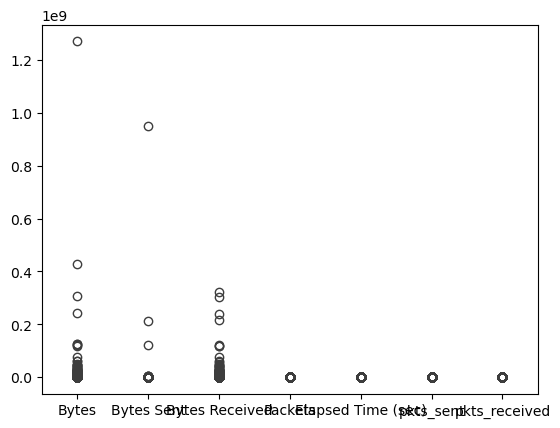

In [8]:
sns.boxplot(df[['Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received']], gap=1)



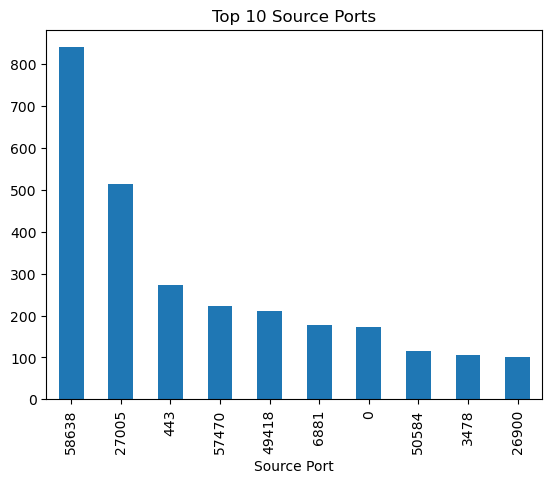

In [9]:
df['Source Port'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Source Ports')
plt.show()


In [10]:
port_traffic = df.groupby(['Source Port', 'Destination Port'])['Bytes'].sum().reset_index()

In [14]:
port_traffic.sort_values

<bound method DataFrame.sort_values of        Source Port  Destination Port   Bytes
0                0                 0   41970
1                5             47993      62
2               20             17095     554
3               20             64488  624666
4               22             15260     130
...            ...               ...     ...
39577        65531                53     379
39578        65532                53    1270
39579        65533                53     277
39580        65533               445      66
39581        65534                53     414

[39582 rows x 3 columns]>

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

num_cols = ['Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received']

class LogScaleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols=num_cols):

        self.numeric_cols = numeric_cols
        self.mean_ = {}
        self.std_ = {}

    def fit(self, X, y=None):
        X_temp = X.copy()
        
        for col in self.numeric_cols:
            # 1. Log transform (log1p handles 0 values safely)
            x_col_log = np.log1p(X_temp[col].values)
            
            # 2. Compute mean and std for standard scaling
            self.mean_[col] = x_col_log.mean()
            self.std_[col]  = x_col_log.std()
        
        return self
    
    def transform(self, X, y=None):
        X_trans = X.copy()
        
        for col in self.numeric_cols:
            # 1. Log transform
            x_col_log = np.log1p(X_trans[col].values)
            
            # 2. Standard scale using learned mean_ and std_
            mean_val = self.mean_[col]
            # Avoid dividing by zero if std_ is extremely small
            std_val  = self.std_[col] if self.std_[col] != 0 else 1e-12
            
            x_col_scaled = (x_col_log - mean_val) / std_val
            
            # 3. Assign transformed data back
            X_trans[col] = x_col_scaled
        
        return X_trans


In [15]:
transformer = LogScaleTransformer()
transformer.fit(df)

LogScaleTransformer()

In [16]:
df_transformed = transformer.transform(df)
print(df_transformed)

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0            57222                53            54587                    53   
1            56258              3389            56258                  3389   
2             6881             50321            43265                 50321   
3            50553              3389            50553                  3389   
4            50002               443            45848                   443   
...            ...               ...              ...                   ...   
65527        63691                80            13237                    80   
65528        50964                80            13485                    80   
65529        54871               445                0                     0   
65530        54870               445                0                     0   
65531        54867               445                0                     0   

      Action     Bytes  Bytes Sent  Bytes Received 

<Axes: >

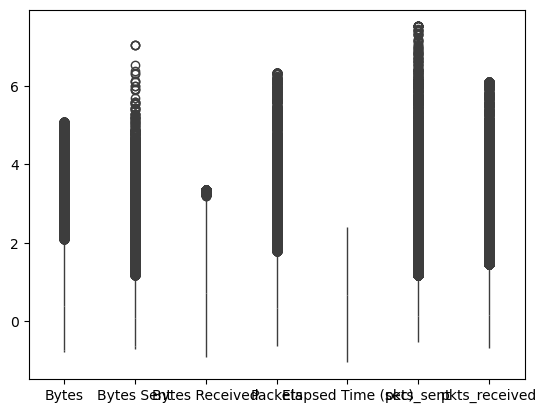

In [20]:
sns.boxplot(df_transformed[['Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received']], gap=1)

In [19]:
df_transformed.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,-0.286935,-0.421305,0.269826,-0.321786,0.658321,-0.518149,-0.143730
1,56258,3389,56258,3389,allow,1.248192,1.375278,1.248027,1.145242,0.389239,1.091576,1.085109
2,6881,50321,43265,50321,allow,-0.149357,-0.278032,0.368168,-0.321786,2.468029,-0.518149,-0.143730
3,50553,3389,50553,3389,allow,1.080227,1.307422,1.108764,0.972687,0.389239,0.902091,0.914734
4,50002,443,45848,443,allow,2.028334,2.293254,1.724611,1.508692,0.360947,1.319296,1.575178


In [17]:
df = df_transformed

In [18]:
onehot = he(sparse_output=False)
s = onehot.fit_transform(df[["Action"]])
encoded_col_names = ["allow", "deny", "drop", "reset-both"]
X_encoded_df = pd.DataFrame(s, columns=encoded_col_names)
df_encoded = pd.concat([df.drop(columns="Action"), X_encoded_df], axis=1)

In [26]:
df_encoded.loc[(df_encoded["drop"]>0) & (df_encoded["Source Port"]<=1023) & (df_encoded["Destination Port"]<=1023)]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,allow,deny,drop,reset-both


In [27]:
df_encoded.loc[(df_encoded["drop"]>0) & (df_encoded["Source Port"]<=1023)] # & (df_encoded["Destination Port"]<=1023)]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,allow,deny,drop,reset-both


In [28]:
df_encoded.loc[(df_encoded["drop"]>0) & (df_encoded["Destination Port"]<=1023)] # all cases where packets dropped

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,allow,deny,drop,reset-both
141,51048,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
142,51045,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
145,55725,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
146,55723,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
147,55724,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65519,49784,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
65520,49783,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
65529,54871,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0
65530,54870,445,0,0,-0.71688,-0.606897,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,1.0,0.0


In [29]:
df_encoded.loc[(df_encoded["reset-both"]>0) & (df_encoded["Source Port"]>1023)] # all reset-both cases

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,allow,deny,drop,reset-both
229,1024,21854,0,0,-0.342834,-0.097705,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
1023,11317,61248,0,0,-0.386220,-0.156766,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
2319,11317,53563,0,0,-0.386220,-0.156766,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
2933,11337,25773,0,0,-0.336952,-0.089698,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
5713,8116,25773,0,0,-0.342834,-0.097705,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
8010,64461,31652,0,0,-0.772780,-0.682994,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
8971,18517,31652,0,0,-0.772780,-0.682994,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
9190,64014,3389,64014,3389,-0.052458,0.124485,0.225308,0.074062,-1.049054,0.137059,-0.143696,0.0,0.0,0.0,1.0
10913,28305,25773,0,0,-0.370259,-0.135039,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0
13988,6889,8970,0,0,-0.386220,-0.156766,-0.925059,-0.637228,-1.049054,-0.519255,-0.676364,0.0,0.0,0.0,1.0


In [30]:
def categorize_port(port):
    header = "source-port"
    if port <= 1023:
        return f'{header} well-known'
    elif port <= 49151:
        return f'{header} registered'
    else:
        return f'{header} dynamic'
    
# Binning
df_encoded['Source Port'] = df_encoded['Source Port'].apply(categorize_port)



In [31]:
def categorize_port(port):
    header = "destination-port"
    if port <= 1023:
        return f'{header} well-known'
    elif port <= 49151:
        return f'{header} registered'
    else:
        return f'{header} dynamic'
    
df_encoded['Destination Port'] = df_encoded['Destination Port'].apply(categorize_port)

In [32]:
def categorize_port(port):
    header = "NAT-source-port"
    if port <= 1023:
        return f'{header} well-known'
    elif port <= 49151:
        return f'{header} registered'
    else:
        return f'{header} dynamic'
    
df_encoded['NAT Source Port'] = df_encoded['NAT Source Port'].apply(categorize_port)

In [33]:
def categorize_port(port):
    header = "NAT-destination-port"
    if port <= 1023:
        return f'{header} well-known'
    elif port <= 49151:
        return f'{header} registered'
    else:
        return f'{header} dynamic'
    
df_encoded['NAT Destination Port'] = df_encoded['NAT Destination Port'].apply(categorize_port)

In [34]:
df_new = pd.get_dummies(df_encoded, 
                    columns=['Source Port', 
                             'Destination Port', 
                             'NAT Source Port', 
                             'NAT Destination Port'])

for col in df_new.columns:
    if df_new[col].dtype == 'bool':
        df_new[col] = df_new[col].astype(int)

In [35]:
df_new.columns

Index(['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'allow', 'deny',
       'drop', 'reset-both', 'Source Port_source-port dynamic',
       'Source Port_source-port registered',
       'Source Port_source-port well-known',
       'Destination Port_destination-port dynamic',
       'Destination Port_destination-port registered',
       'Destination Port_destination-port well-known',
       'NAT Source Port_NAT-source-port dynamic',
       'NAT Source Port_NAT-source-port registered',
       'NAT Source Port_NAT-source-port well-known',
       'NAT Destination Port_NAT-destination-port dynamic',
       'NAT Destination Port_NAT-destination-port registered',
       'NAT Destination Port_NAT-destination-port well-known'],
      dtype='object')